# Raylegh Taylor instability with Free-Surface: The Drunken sailor effect

![Kaus2010_figure1.png](./Kaus2010_figure1.png)

Rayleigh–Taylor instability of a dense, more viscous layer ($\rho$ = 3300 kg/m3 , $\mu = 1e21$ Pa s), sinking through a less dense fluid ( = 3200 kg/m3 ,  = 1020 Pa s). Side boundaries
are free slip, the lower boundary is no-slip and the upper boundary is a free surface. The box is 500 × 500 km in size, and gravitational acceleration was 9.81 m/s2 . The initial
perturbation was sinusoidal with initial amplitude of 5 km. A constant time step of 2500 years (A) or 5000 years (B) was employed, with Q2 P−1 quadrilateral elements and
51 × 51 nodes. Whereas the 2500 years simulation evolves smoothly, the simulation with t = 5000 years results in a sloshing instability, in which the velocity pattern
changes direction from one time step to the other.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /opt/venv/lib/python3.9/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.0 * u.centimeter / u.year
model_length = 500 * u.km
bodyforce = 3300 * u.kg / u.m**3 * 9.81 * u.m / u.s**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

## Model Geometry

In [4]:
gravity_vector = (0.0, -9.81 * u.m / u.s**2)

In [5]:
Model = GEO.Model(elementRes=(50, 50), 
                  elementType="Q2/dPc1",
                  minCoord=(-250. * u.km, -500. * u.km), 
                  maxCoord=(250. * u.km, 0. * u.km), 
                  gravity=gravity_vector)

	Global element size: 50x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x50


In [6]:
Model.outputDir="outputs_kaus2010_FreeSurface_100ka"
#Model.outputDir="outputs_kaus2010_FreeSurface"

In [7]:
import underworld.function as fn

In [8]:
import numpy as np

amplitude = GEO.non_dimensionalise(5*u.km)
period = GEO.non_dimensionalise(Model.length) #* 2.0
interface_depth = GEO.non_dimensionalise(100*u.km)
func = -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

shape = fn.input()[1] < -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

In [9]:
HD_material = Model.add_material(name="HD_material", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
LD_material = Model.add_material(name="LD_material", shape=shape)

In [10]:
npoints = 250
coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = -interface_depth + (amplitude * np.cos(2.0*np.pi*coords[:, 0]/period))
#surf_tracers = Model.add_passive_tracers(name="Surface",vertices=coords)
Model.add_passive_tracers(name="Surface", vertices=coords)


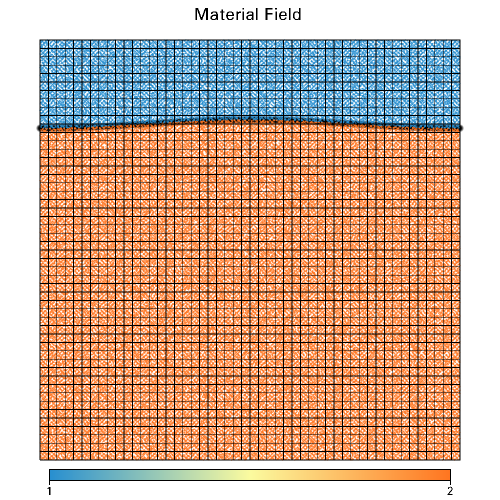

In [11]:
Fig = vis.Figure(figsize=(500,500), title="Material Field", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model.mesh)
Fig.Points(Model.Surface_tracers, pointSize=8.0)
Fig.show()

In [12]:
LD_material.density = 3200 * u.kilogram / u.meter**3
HD_material.density = 3300 * u.kilogram / u.meter**3
LD_material.viscosity = 1e20 * u.pascal * u.second
HD_material.viscosity = 1e21 * u.pascal * u.second

## Boundary Conditions

In [13]:
Model.set_kinematicBCs(left=[0., None],
                       right=[0., None],
                       top=[None, None],
                       bottom=[None,0.],
                       order_wall_conditions=[ "top", "left", "right", "bottom"])

In [14]:
Model.freeSurface = True

	Global element size: 50x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x50


In [15]:
Model.fssa_factor = 1.0

# Compute initial condition

In [16]:
Model.init_model(pressure="lithostatic")

/opt/venv/lib/python3.9/site-packages/UWGeodynamics/_model.py:1566: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")



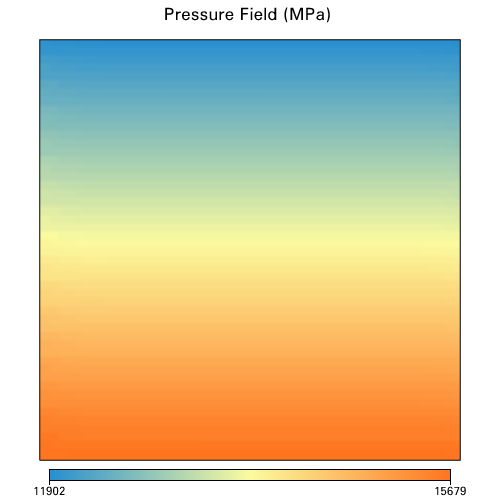

In [17]:
Fig = vis.Figure(figsize=(500,500), title="Pressure Field (MPa)", quality=3)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal))
Fig.show()


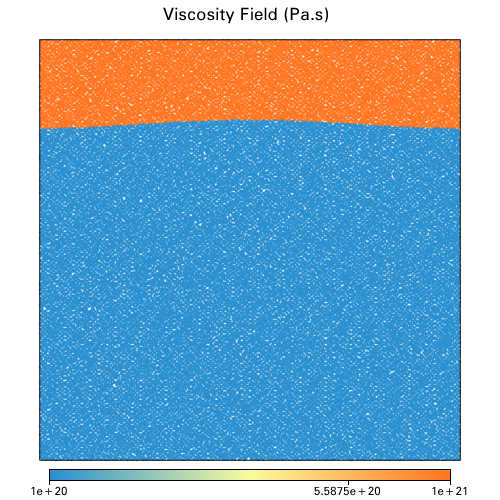

In [18]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.show()


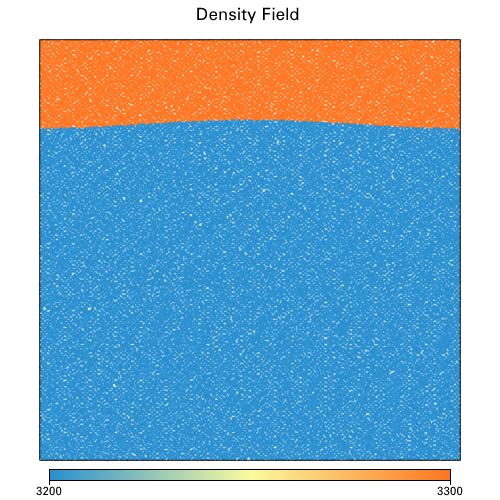

In [19]:
Fig = vis.Figure(figsize=(500,500), title="Density Field", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.densityField, u.kg / u.m**3),
           fn_size=3.0)
Fig.show()

## Solver options

In [20]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

outputss=['pressureField',
         'strainRateField',
         'velocityField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projDensityField',
         'projStressTensor',]
GEO.rcParams['default.outputs']=outputss

In [21]:
Model.run_for(6.0 * u.megayears, checkpoint_interval=100000*u.year,dt=100000*u.year)
#Model.run_for(5.5 * u.megayears, checkpoint_interval=100000*u.year,dt=5000*u.year)

Running with UWGeodynamics version 2.12.1
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033801 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03126 secs / 1 its
  Pressure Solve:         = 0.08879 secs / 4 its
  Final V Solve:          = 0.01839 secs / 1 its

  Total BSSCR Linear solve time: 0.801842 seconds

Linear solver (KCXCI379__system-execute), solution time 8.084199e-01 (secs)
Time Integration
	2nd order:

Step:     6 Model Time: 600000.0 year dt: 100000.0 year (2022-02-06 13:57:41)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020385 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01281 secs / 1 its
  Pressure Solve:         = 0.05669 secs / 4 its
  Final V Solve:          = 0.01318 secs / 1 its

  Total BSSCR Linear solve time: 0.424066 seconds

Linear solver (KCXCI379__system-execute), solution time 4.249928e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1552 [min] /    0.1552 [max] (secs)
Time Integration - 0.155223 [min] / 0.155223 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.069991e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0006 [min] / 

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1418 [min] /    0.1418 [max] (secs)
Time Integration - 0.141802 [min] / 0.141802 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.828939e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0006 [min] /    0.0006 [max] (secs)
Time Integration - 0.000650999 [min] / 0.000650999 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    13 Model Time: 1.3 megayear dt: 100000.0 year (2022-02-06 13:58:32)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021787 seconds

  Settin

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000490058 [min] / 0.000490058 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    19 Model Time: 1.9 megayear dt: 100000.0 year (2022-02-06 13:59:21)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021890 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01388 secs / 1 its
  Pressure Solve:         = 0.05577 secs / 4 its
  Final V Solve:          = 0.01712 secs / 1 its

  Total BSSCR Linear solve time: 0.490139 seconds

Linear solver (KCXCI379__system-execu

Step:    25 Model Time: 2.5 megayear dt: 100000.0 year (2022-02-06 14:00:00)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018726 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01321 secs / 1 its
  Pressure Solve:         = 0.05379 secs / 4 its
  Final V Solve:          = 0.01257 secs / 1 its

  Total BSSCR Linear solve time: 0.382081 seconds

Linear solver (KCXCI379__system-execute), solution time 3.830366e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1591 [min] /    0.1591 [max] (secs)
Time Integration - 0.159146 [min] / 0.159146 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 4.143176e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0008 [min] /  

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2146 [min] /    0.2146 [max] (secs)
Time Integration - 0.214686 [min] / 0.214686 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 2.912480e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000542812 [min] / 0.000542812 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    32 Model Time: 2.9 megayear dt: 52617.1 year (2022-02-06 14:00:40)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018847 seconds

  Setting

	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000578625 [min] / 0.000578625 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    38 Model Time: 3.2 megayear dt: 58251.9 year (2022-02-06 14:01:13)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021451 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.013 secs / 1 its
  Pressure Solve:         = 0.05486 secs / 4 its
  Final V Solve:          = 0.01275 secs / 1 its

  Total BSSCR Linear solve time: 0.348816 seconds

Linear solver (KCXCI379__system-execute), solution time 3

Step:    44 Model Time: 3.4 megayear dt: 4046.4 year (2022-02-06 14:01:47)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018198 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0129 secs / 1 its
  Pressure Solve:         = 0.05877 secs / 4 its
  Final V Solve:          = 0.0187 secs / 1 its

  Total BSSCR Linear solve time: 0.333040 seconds

Linear solver (KCXCI379__system-execute), solution time 3.339687e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1647 [min] /    0.1647 [max] (secs)
Time Integration - 0.164702 [min] / 0.164702 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.178784e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1601 [min] /    0.1601 [max] (secs)
Time Integration - 0.160183 [min] / 0.160183 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 2.766085e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000544458 [min] / 0.000544458 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    51 Model Time: 3.6 megayear dt: 38073.2 year (2022-02-06 14:02:20)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018746 seconds

  Setting

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020893 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01299 secs / 1 its
  Pressure Solve:         = 0.05363 secs / 4 its
  Final V Solve:          = 0.01287 secs / 1 its

  Total BSSCR Linear solve time: 0.322489 seconds

Linear solver (KCXCI379__system-execute), solution time 3.234130e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1339 [min] /    0.1339 [max] (secs)
Time Integration - 0.133971 [min] / 0.133971 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 2.894054e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0009 [min] /    0.0009 [max] (secs)
Time Integration - 0.000912069 [min] / 0.000912069 [max

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1405 [min] /    0.1405 [max] (secs)
Time Integration - 0.140545 [min] / 0.140545 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 6.587684e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0006 [min] /    0.0006 [max] (secs)
Time Integration - 0.000599872 [min] / 0.000599872 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    64 Model Time: 4.0 megayear dt: 13684.3 year (2022-02-06 14:03:24)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.018909 seconds

  Setting

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.017857 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0127 secs / 1 its
  Pressure Solve:         = 0.0536 secs / 4 its
  Final V Solve:          = 0.01265 secs / 1 its

  Total BSSCR Linear solve time: 0.317883 seconds

Linear solver (KCXCI379__system-execute), solution time 3.188196e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1378 [min] /    0.1378 [max] (secs)
Time Integration - 0.137849 [min] / 0.137849 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.386727e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0007 [min] /    0.0007 [max] (secs)
Time Integration - 0.000732315 [min] / 0.000732315 [max] 

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1711 [min] /    0.1711 [max] (secs)
Time Integration - 0.171125 [min] / 0.171125 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 4.054702e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0006 [min] /    0.0006 [max] (secs)
Time Integration - 0.000607985 [min] / 0.000607985 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    77 Model Time: 4.3 megayear dt: 21349.2 year (2022-02-06 14:04:26)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.022201 seconds

  Setting

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000799943 [min] / 0.000799943 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    83 Model Time: 4.4 megayear dt: 19303.4 year (2022-02-06 14:05:00)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021068 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01401 secs / 1 its
  Pressure Solve:         = 0.05912 secs / 4 its
  Final V Solve:          = 0.01209 secs / 1 its

  Total BSSCR Linear solve time: 0.390127 seconds

Linear solver (KCXCI379__system-execut

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020128 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02583 secs / 1 its
  Pressure Solve:         = 0.05914 secs / 4 its
  Final V Solve:          = 0.009587 secs / 1 its

  Total BSSCR Linear solve time: 0.452026 seconds

Linear solver (KCXCI379__system-execute), solution time 4.530507e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2505 [min] /    0.2505 [max] (secs)
Time Integration - 0.250549 [min] / 0.250549 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.236229e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000485494 [min] / 0.000485494 [ma

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2311 [min] /    0.2311 [max] (secs)
Time Integration - 0.231181 [min] / 0.231181 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 4.130875e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000492363 [min] / 0.000492363 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:    96 Model Time: 4.6 megayear dt: 15908.1 year (2022-02-06 14:06:15)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019362 seconds

  Setting

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0007 [min] /    0.0007 [max] (secs)
Time Integration - 0.000755857 [min] / 0.000755857 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   102 Model Time: 4.7 megayear dt: 14729.8 year (2022-02-06 14:06:50)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032215 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03086 secs / 1 its
  Pressure Solve:         = 0.1497 secs / 4 its
  Final V Solve:          = 0.01536 secs / 1 its

  Total BSSCR Linear solve time: 0.909083 seconds

Linear solver (KCXCI379__system-execute

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020662 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01379 secs / 1 its
  Pressure Solve:         = 0.05727 secs / 4 its
  Final V Solve:          = 0.01257 secs / 1 its

  Total BSSCR Linear solve time: 0.395312 seconds

Linear solver (KCXCI379__system-execute), solution time 3.968267e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1664 [min] /    0.1664 [max] (secs)
Time Integration - 0.166444 [min] / 0.166444 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.628112e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000471238 [min] / 0.000471238 [max

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2097 [min] /    0.2097 [max] (secs)
Time Integration - 0.209708 [min] / 0.209708 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.318927e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000525775 [min] / 0.000525775 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   115 Model Time: 4.8 megayear dt: 12523.1 year (2022-02-06 14:08:13)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020471 seconds

  Setting

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0007 [min] /    0.0007 [max] (secs)
Time Integration - 0.000717797 [min] / 0.000717797 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   121 Model Time: 4.9 megayear dt: 1497.8 year (2022-02-06 14:08:50)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.037354 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0144 secs / 1 its
  Pressure Solve:         = 0.061 secs / 4 its
  Final V Solve:          = 0.01121 secs / 1 its

  Total BSSCR Linear solve time: 0.475989 seconds

Linear solver (KCXCI379__system-execute), 

Step:   127 Model Time: 5.0 megayear dt: 11070.3 year (2022-02-06 14:09:23)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.028743 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01404 secs / 1 its
  Pressure Solve:         = 0.07266 secs / 4 its
  Final V Solve:          = 0.01397 secs / 1 its

  Total BSSCR Linear solve time: 0.414141 seconds

Linear solver (KCXCI379__system-execute), solution time 4.151882e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1617 [min] /    0.1617 [max] (secs)
Time Integration - 0.161767 [min] / 0.161767 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.404587e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0008 [min] /   

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1660 [min] /    0.1660 [max] (secs)
Time Integration - 0.166089 [min] / 0.166089 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 4.659424e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000517602 [min] / 0.000517602 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   134 Model Time: 5.0 megayear dt: 10323.2 year (2022-02-06 14:10:05)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020417 seconds

  Setting

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000594647 [min] / 0.000594647 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   140 Model Time: 5.1 megayear dt: 7558.7 year (2022-02-06 14:10:41)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019755 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0142 secs / 1 its
  Pressure Solve:         = 0.08241 secs / 4 its
  Final V Solve:          = 0.01077 secs / 1 its

  Total BSSCR Linear solve time: 0.439363 seconds

Linear solver (KCXCI379__system-execute)

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032412 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01523 secs / 1 its
  Pressure Solve:         = 0.06281 secs / 4 its
  Final V Solve:          = 0.01424 secs / 1 its

  Total BSSCR Linear solve time: 0.472948 seconds

Linear solver (KCXCI379__system-execute), solution time 4.740055e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1581 [min] /    0.1581 [max] (secs)
Time Integration - 0.158096 [min] / 0.158096 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.263479e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.00050568 [min] / 0.00050568 [max] 

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1536 [min] /    0.1536 [max] (secs)
Time Integration - 0.153676 [min] / 0.153676 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.973686e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0014 [min] /    0.0014 [max] (secs)
Time Integration - 0.00141766 [min] / 0.00141766 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   153 Model Time: 5.2 megayear dt: 9069.3 year (2022-02-06 14:11:59)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030240 seconds

  Setting sc

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000520367 [min] / 0.000520367 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   159 Model Time: 5.3 megayear dt: 8836.9 year (2022-02-06 14:12:34)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020060 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01392 secs / 1 its
  Pressure Solve:         = 0.05845 secs / 4 its
  Final V Solve:          = 0.01262 secs / 1 its

  Total BSSCR Linear solve time: 0.361682 seconds

Linear solver (KCXCI379__system-execute

Step:   165 Model Time: 5.3 megayear dt: 8682.8 year (2022-02-06 14:13:13)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.019568 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01401 secs / 1 its
  Pressure Solve:         = 0.05924 secs / 4 its
  Final V Solve:          = 0.01199 secs / 1 its

  Total BSSCR Linear solve time: 0.387088 seconds

Linear solver (KCXCI379__system-execute), solution time 3.880823e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1537 [min] /    0.1537 [max] (secs)
Time Integration - 0.153804 [min] / 0.153804 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.444236e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0006 [min] /    

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2833 [min] /    0.2833 [max] (secs)
Time Integration - 0.283318 [min] / 0.283318 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 5.158346e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000841791 [min] / 0.000841791 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   172 Model Time: 5.4 megayear dt: 8574.1 year (2022-02-06 14:13:57)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.061431 seconds

  Setting 

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000862348 [min] / 0.000862348 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   178 Model Time: 5.4 megayear dt: 8628.2 year (2022-02-06 14:14:36)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026800 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0146 secs / 1 its
  Pressure Solve:         = 0.062 secs / 4 its
  Final V Solve:          = 0.01113 secs / 1 its

  Total BSSCR Linear solve time: 0.386665 seconds

Linear solver (KCXCI379__system-execute), 

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.028799 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01438 secs / 1 its
  Pressure Solve:         = 0.05999 secs / 4 its
  Final V Solve:          = 0.01167 secs / 1 its

  Total BSSCR Linear solve time: 0.436501 seconds

Linear solver (KCXCI379__system-execute), solution time 4.467680e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1621 [min] /    0.1621 [max] (secs)
Time Integration - 0.162126 [min] / 0.162126 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.412937e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000509035 [min] / 0.000509035 [max

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2078 [min] /    0.2078 [max] (secs)
Time Integration - 0.207812 [min] / 0.207812 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 4.360376e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000583089 [min] / 0.000583089 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   191 Model Time: 5.5 megayear dt: 8472.3 year (2022-02-06 14:16:05)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.022707 seconds

  Setting 

In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   197 Model Time: 5.6 megayear dt: 8382.3 year (2022-02-06 14:16:52)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.063711 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0433 secs / 1 its
  Pressure Solve:         = 0.1162 secs / 4 its
  Final V Solve:          = 0.02606 secs / 1 its

  Total BSSCR Linear solve time: 1.198432 seconds

Linear solver (KCXCI379__system-execute), solution time 1.208010e+00 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2986 [min] /    0.2986 [max] (secs)
Time Integration - 0.298701 [

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.020805 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01444 secs / 1 its
  Pressure Solve:         = 0.06726 secs / 4 its
  Final V Solve:          = 0.009638 secs / 1 its

  Total BSSCR Linear solve time: 0.424398 seconds

Linear solver (KCXCI379__system-execute), solution time 4.254353e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1739 [min] /    0.1739 [max] (secs)
Time Integration - 0.173983 [min] / 0.173983 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.948399e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000485821 [min] / 0.000485821 [ma

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.1920 [min] /    0.1920 [max] (secs)
Time Integration - 0.192104 [min] / 0.192104 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.648507e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0008 [min] /    0.0008 [max] (secs)
Time Integration - 0.000822698 [min] / 0.000822698 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   210 Model Time: 5.7 megayear dt: 9423.6 year (2022-02-06 14:18:36)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024629 seconds

  Setting 

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0006 [min] /    0.0006 [max] (secs)
Time Integration - 0.000674795 [min] / 0.000674795 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   216 Model Time: 5.8 megayear dt: 10706.2 year (2022-02-06 14:19:27)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.041375 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0144 secs / 1 its
  Pressure Solve:         = 0.0606 secs / 4 its
  Final V Solve:          = 0.0134 secs / 1 its

  Total BSSCR Linear solve time: 0.757769 seconds

Linear solver (KCXCI379__system-execute),

Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.034949 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.04295 secs / 1 its
  Pressure Solve:         = 0.1047 secs / 4 its
  Final V Solve:          = 0.01596 secs / 1 its

  Total BSSCR Linear solve time: 0.883290 seconds

Linear solver (KCXCI379__system-execute), solution time 8.846842e-01 (secs)
Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2031 [min] /    0.2031 [max] (secs)
Time Integration - 0.203159 [min] / 0.203159 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.293765e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0007 [min] /    0.0007 [max] (secs)
Time Integration - 0.000700659 [min] / 0.000700659 [max]

Time Integration
	2nd order:                 TMQ28VGB__integrand -    0.2046 [min] /    0.2046 [max] (secs)
Time Integration - 0.204665 [min] / 0.204665 [max] (secs)
Linear solver (K4PVP1IY__system-execute) 
Linear solver (K4PVP1IY__system-execute), solution time 3.568520e-02 (secs)
Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0014 [min] /    0.0014 [max] (secs)
Time Integration - 0.00147269 [min] / 0.00147269 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   229 Model Time: 5.9 megayear dt: 11041.4 year (2022-02-06 14:21:25)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.029660 seconds

  Setting s

Time Integration
	2nd order:                 M01Z3EJQ__integrand -    0.0007 [min] /    0.0007 [max] (secs)
Time Integration - 0.000762505 [min] / 0.000762505 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "XHT4IN1I__swarm"
	done 33% (834 cells)...
	done 67% (1667 cells)...
	done 100% (2500 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "XHT4IN1I__swarm"
Step:   235 Model Time: 6.0 megayear dt: 13582.6 year (2022-02-06 14:22:10)
Linear solver (KCXCI379__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.021456 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01421 secs / 1 its
  Pressure Solve:         = 0.05874 secs / 4 its
  Final V Solve:          = 0.01196 secs / 1 its

  Total BSSCR Linear solve time: 0.409190 seconds

Linear solver (KCXCI379__system-execut

1

In [22]:
#Model.run_for(nstep=55, checkpoint_interval=1, dt=100000*u.year)
#Model.run_for(nstep=1100, checkpoint_interval=1, dt=5000*u.year)


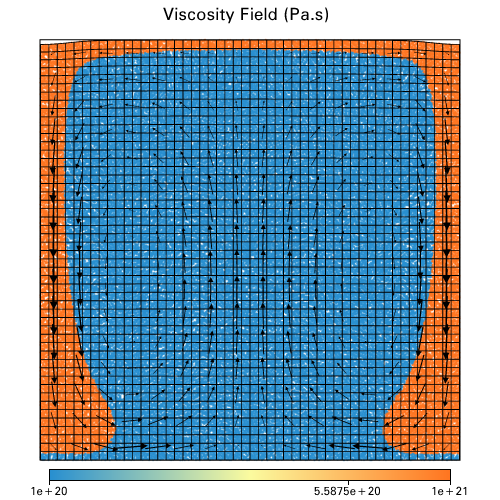

In [23]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Mesh(Model.mesh)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()